In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor

In [2]:
bridgeport_df = pd.read_csv('data/solar_filtered/bridgeport_solar_filtered.csv', index_col='Unnamed: 0').loc[:, ['Glo Mod (Wh/m^2)']]
jfk_df =pd.read_csv('data/solar_filtered/jfk_solar_filtered.csv', index_col='Unnamed: 0').loc[:, ['Glo Mod (Wh/m^2)']]
laguardia_df = pd.read_csv('data/solar_filtered/laguardia_solar_filtered.csv', index_col='Unnamed: 0').loc[:, ['Glo Mod (Wh/m^2)']]
newark_df = pd.read_csv('data/solar_filtered/newark_solar_filtered.csv', index_col='Unnamed: 0').loc[:, ['Glo Mod (Wh/m^2)']]
li_macarthur_df = pd.read_csv('data/solar_filtered/li_macarthur_solar_filtered.csv', index_col='Unnamed: 0').loc[:, ['Glo Mod (Wh/m^2)']]
p_duchess_df = pd.read_csv('data/solar_filtered/p_duchess_filtered.csv', index_col='Unnamed: 0').loc[:, ['Glo Mod (Wh/m^2)']]
stewart_df =pd.read_csv('data/solar_filtered/stewart_filtered.csv', index_col='Unnamed: 0').loc[:, ['Glo Mod (Wh/m^2)']]
white_plains_df = pd.read_csv('data/solar_filtered/white_plains_filtered.csv', index_col='Unnamed: 0').loc[:, ['Glo Mod (Wh/m^2)']]
republic_df = pd.read_csv('data/solar_filtered/republic_filtered.csv', index_col='Unnamed: 0').loc[:, ['Glo Mod (Wh/m^2)']]
caldwell_df = pd.read_csv('data/solar_filtered/caldwell_filtered.csv', index_col='Unnamed: 0').loc[:, ['Glo Mod (Wh/m^2)']]
danbury_df = pd.read_csv('data/solar_filtered/danbury_filtered.csv', index_col='Unnamed: 0').loc[:, ['Glo Mod (Wh/m^2)']]

In [3]:
bridgeport_df['name'] = "Bridgeport"
jfk_df['name'] = "JFK"
laguardia_df['name'] = "LAG"
newark_df['name'] = "EWR"
li_macarthur_df['name'] = "Macarthur"
p_duchess_df['name'] = "p_duchess"
stewart_df['name'] = "stewart"
white_plains_df['name'] = "white_plains"
republic_df['name'] = "republic"
caldwell_df['name'] = "caldwell"
danbury_df['name'] = "danbury"

In [25]:
def get_nrel_data():
    df = pd.DataFrame()
    for year in range(2006, 2011):
        year_df = pd.read_csv("data/statue_of_lib_data/1242368_40.69_-74.06_" + str(year) + ".csv", skiprows=2)
        df = pd.concat([df, year_df])
    df = df.groupby(by=["Year", "Month", "Day", "Hour"]).mean().reset_index()
    df['Timestamp'] = df['Year'].astype(str) + "-" + df['Month'].astype(str).apply(lambda x: x.zfill(2)) + "-" + df['Day'].astype(str).apply(lambda x: x.zfill(2)) + " " + df['Hour'].astype(str).apply(lambda x: x.zfill(2)) + ":00:00" 
    df.set_index('Timestamp', inplace = True)
    df.drop(columns=["Year", "Month", "Day", "Hour", "Minute"], inplace=True)
    return df

stat_of_lib = get_nrel_data()
stat_of_lib.head(24)

,GHI
Timestamp,
2006-01-01 00:00:00,0.0
2006-01-01 01:00:00,0.0
2006-01-01 02:00:00,0.0
2006-01-01 03:00:00,0.0
2006-01-01 04:00:00,0.0
2006-01-01 05:00:00,0.0
2006-01-01 06:00:00,0.0
2006-01-01 07:00:00,0.0
2006-01-01 08:00:00,15.0


Include lat and lons with the solar irradiance values of the 11 neighbors we are using to predict the solar irradiance values for the empire state building hourly.

In [5]:
stations = pd.read_csv("stations.csv").drop(columns=["id", "altitude (m)"])
stations

,name,lat,lon
0,Macarthur,40.783,-73.100
1,EWR,40.717,-74.183
2,JFK,40.650,-73.800
3,LAG,40.783,-70.883
4,Bridgeport,41.183,-73.150
5,p_duchess,41.633,-73.883
6,stewart,41.500,-74.100
7,white_plains,41.067,-73.717
8,republic,40.717,-73.417
9,caldwell,40.883,-74.283


In [6]:
# ts is a string in the form of "2008-06-02 10:00:00".
def get_knn_predict_for_ts(ts):
    all_data = pd.DataFrame()
    all_data = pd.concat([all_data, stations.merge(bridgeport_df[bridgeport_df.index == ts], on="name")]).drop(columns="name")
    all_data = pd.concat([all_data, stations.merge(jfk_df[jfk_df.index == ts], on="name")]).drop(columns="name")
    all_data = pd.concat([all_data, stations.merge(laguardia_df[laguardia_df.index == ts], on="name")]).drop(columns="name")
    all_data = pd.concat([all_data, stations.merge(newark_df[newark_df.index == ts], on="name")]).drop(columns="name")
    all_data = pd.concat([all_data, stations.merge(li_macarthur_df[li_macarthur_df.index == ts], on="name")]).drop(columns="name")
    all_data = pd.concat([all_data, stations.merge(p_duchess_df[p_duchess_df.index == ts], on="name")]).drop(columns="name")
    all_data = pd.concat([all_data, stations.merge(stewart_df[stewart_df.index == ts], on="name")]).drop(columns="name")
    all_data = pd.concat([all_data, stations.merge(white_plains_df[white_plains_df.index == ts], on="name")]).drop(columns="name")
    all_data = pd.concat([all_data, stations.merge(republic_df[republic_df.index == ts], on="name")]).drop(columns="name")
    all_data = pd.concat([all_data, stations.merge(caldwell_df[caldwell_df.index == ts], on="name")]).drop(columns="name")
    all_data = pd.concat([all_data, stations.merge(danbury_df[danbury_df.index == ts], on="name")]).drop(columns="name")
    X = all_data.drop(columns=["Glo Mod (Wh/m^2)"])
    y = all_data.loc[:, ["Glo Mod (Wh/m^2)"]]
    
    neigh = KNeighborsRegressor(n_neighbors=11, weights="distance")
    neigh.fit(X, y)
    return neigh.predict([[40.69, -74.06]])

In [7]:
print("Predicted by KNN: " + str(get_knn_predict_for_ts("2008-06-02 10:00:00")[0][0]))
print("Actual by NREL Model: " + str(stat_of_lib[stat_of_lib.index == "2008-06-02 10:00:00"].iloc[0, 0]))

Predicted by KNN: 793.9888296649526
Actual by NREL Model: 904.5


Let's use this for a whole summer and observe how the predicted and actual global irradiance levels relate.

In [29]:
from itertools import chain

index_list = stat_of_lib.index.tolist()

def get_knn_month_data(month):
    def create_hour_list(month, hour):
        start_index = index_list.index("2008-" + str(month).zfill(2) + "-01 " + str(hour).zfill(2) + ":00:00")
        end_index = index_list.index("2008-" + str(month+1).zfill(2) + "-01 " + str(hour).zfill(2) + ":00:00")
        return index_list[start_index:end_index:24]

    ten_list, eleven_list, twelve_list, thirteen_list, fourteen_list, fifteen_list = create_hour_list(month, 10), create_hour_list(month, 11), create_hour_list(month, 12), create_hour_list(month, 13), create_hour_list(month, 14), create_hour_list(month, 15)
    time_list = list(chain.from_iterable(zip(ten_list, eleven_list, twelve_list, thirteen_list, fourteen_list, fifteen_list)))


    predictions = []
    actuals = []
    for ts in time_list:
        predictions.append(get_knn_predict_for_ts(ts)[0][0])
        actuals.append(stat_of_lib[stat_of_lib.index == ts].iloc[0, 0])
    return time_list, predictions, actuals

In [30]:
import matplotlib.pyplot as plt

def plot_knn(time_list, predictions, actuals, title):
    plt.plot(time_list, predictions, label="Predicted")
    plt.scatter(time_list, actuals, label="Actual")
    plt.xticks([time_list[0], time_list[int(len(time_list)/2)], time_list[-1]])
    plt.xlabel("Time")
    plt.xlabel("GHI (Wh/m^2)")
    plt.legend()
    plt.title(title)

    plt.show()

### June 2008 KNN visualization

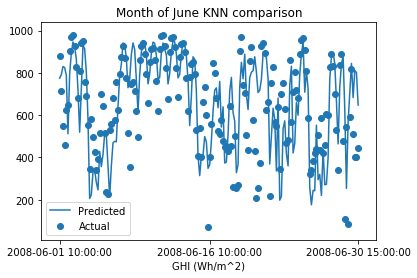

In [34]:
june_time_list, june_predictions, june_actuals = get_knn_month_data(6)
plot_knn(june_time_list, june_predictions, june_actuals, "Month of June KNN comparison")

### January 2008 KNN visualization

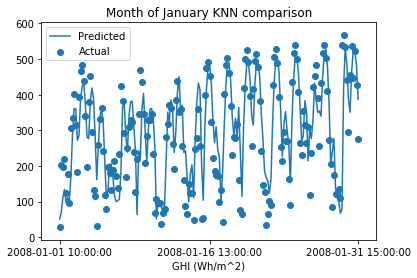

In [35]:
jan_time_list, jan_predictions, jan_actuals = get_knn_month_data(1)
plot_knn(jan_time_list, jan_predictions, jan_actuals, "Month of January KNN comparison")